# Import Libraries

In [ ]:
from pathlib import Path
import numpy as np
import pandas
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import datetime
now = datetime.datetime.now

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
import torchvision
from torchvision import transforms
import copy

# Data Loading

In [ ]:
# Import the helper code for data loading
from codes.data_loader import SingleTask_DataSet

# Folder with images
imgs_folder_path = Path("data/images/")
# File with labels
labels_path = Path("data/labels.xlsx")
 
# Resize all images to 256x256 pixels
img_dim = 256
transform_img = transforms.Compose([transforms.Resize((img_dim, img_dim)), transforms.ToTensor()])

# Get the images 
BUS = SingleTask_DataSet(imgs_folder_path, transform_img, labels_path)

# Print the number of images in the dataset
num_imgs = len(BUS)
print("Number of images:", num_imgs)

# Print the images shape
print('Images shape:', BUS[0][0].shape)

Number of images: 562
Images shape: torch.Size([3, 256, 256])


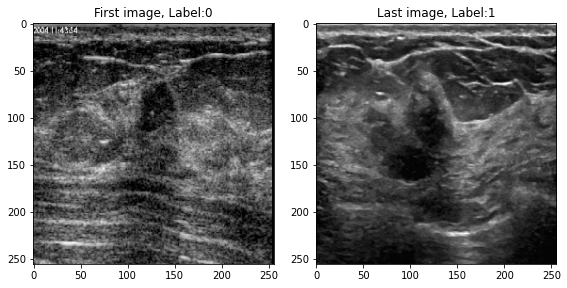

In [ ]:
# Plot the first and last images
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(np.squeeze(BUS[0][0][0]), cmap = "gray")
plt.title('First image, Label:' + str(BUS[0][1]))
plt.subplot(122)
plt.imshow(np.squeeze(BUS[-1][0][0]), cmap = "gray")
plt.title('Last image, Label:' + str(BUS[-1][1]))
plt.tight_layout()
plt.show()

# Training and Testing for One Epoch

In [ ]:
# Train the model for one epoch on the given set
def train(model, device, train_loader, criterion, optimizer, epoch):
    sum_loss, sum_correct = 0, 0

    # Switch to train mode
    model.train()

    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)

        # Compute the output
        output = model(data)

        # Compute the classification loss and accuracy
        loss = criterion(output, target)
        pred = output.max(1)[1]
        sum_correct += pred.eq(target).sum().item()
        sum_loss += len(data) * loss.item()

        # Compute the gradient and do an SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Return the error and cross-entropy loss
    return 1 - (sum_correct / len(train_loader.dataset)), sum_loss / len(train_loader.dataset)


# Evaluate the model on the given set
def validate(model, device, val_loader, criterion):
    sum_loss, sum_correct = 0, 0
    
    # Switch to evaluation mode
    model.eval()
        
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            data, target = data.to(device, dtype=torch.float), target.to(device)

            # Compute the output
            output = model(data)

            # Compute the classification loss and accuracy
            loss = criterion(output, target)
            pred = output.max(1)[1]
            sum_correct += pred.eq(target).sum().item()
            sum_loss += len(data) * loss.item()

    # Return error and cross-entropy loss
    return 1 - (sum_correct / len(val_loader.dataset)), sum_loss / len(val_loader.dataset)

# Model Training

In [ ]:
# Define training parameters 

# Images channels and number of classes
nchannels, nclasses  = 3, 2

# Other parameters
learningrate = 1e-5
batchsize = 2

# Total number of epochs
epochs = 2000
# If verbose=1 print the training and validation loss and accuracy
verbose = 0

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import the model
from codes.model import Network_SingleTask

# Import the complexity measures
from codes.complexity_measures import get_all_measures

################################################################################
Fold 1
Number of train instances: 360, Number of validation instances: 89, Number of test instances: 113

Stopping.
Training time: 0:16:15.515393


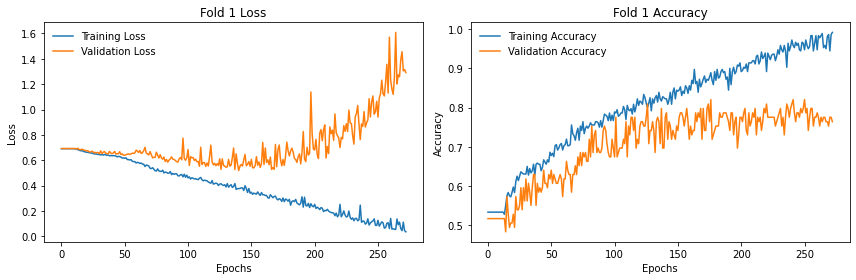


Test dataset performance: Test cross-entropy loss: 0.920 	 Test accuracy: 0.779

Calculate complexity measures!
Time for calculating the measures: 0:04:18.913960

################################################################################
Fold 2
Number of train instances: 360, Number of validation instances: 89, Number of test instances: 113

Stopping.
Training time: 0:11:10.384121


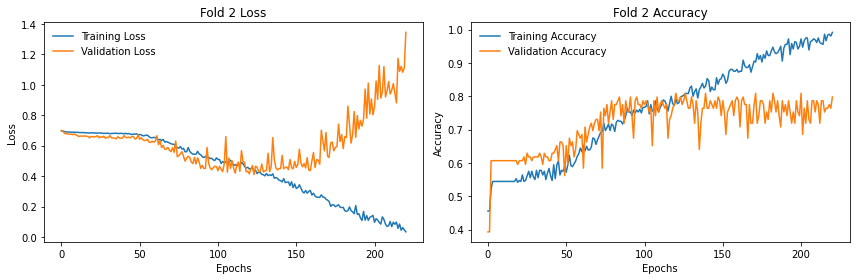


Test dataset performance: Test cross-entropy loss: 1.802 	 Test accuracy: 0.796

Calculate complexity measures!
Time for calculating the measures: 0:03:48.325845

################################################################################
Fold 3
Number of train instances: 360, Number of validation instances: 90, Number of test instances: 112

Stopping.
Training time: 0:14:02.424893


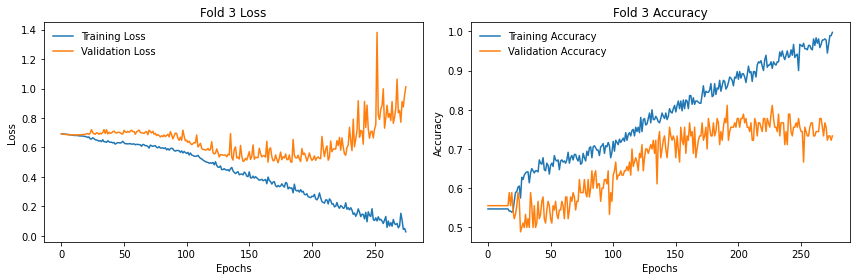


Test dataset performance: Test cross-entropy loss: 1.501 	 Test accuracy: 0.688

Calculate complexity measures!
Time for calculating the measures: 0:04:20.618093

################################################################################
Fold 4
Number of train instances: 360, Number of validation instances: 90, Number of test instances: 112

Stopping.
Training time: 0:11:40.289364


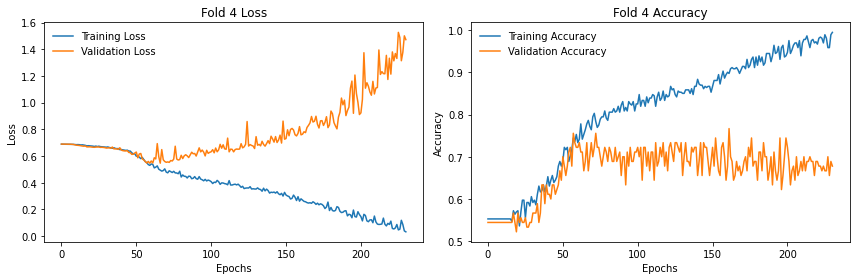


Test dataset performance: Test cross-entropy loss: 1.153 	 Test accuracy: 0.759

Calculate complexity measures!
Time for calculating the measures: 0:05:33.845373

################################################################################
Fold 5
Number of train instances: 360, Number of validation instances: 90, Number of test instances: 112

Stopping.
Training time: 0:11:58.549197


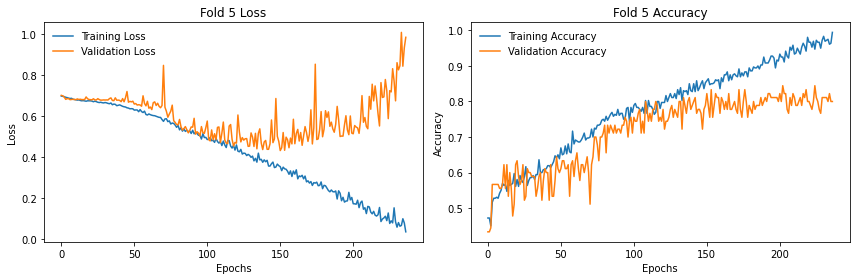


Test dataset performance: Test cross-entropy loss: 0.977 	 Test accuracy: 0.804

Calculate complexity measures!
Time for calculating the measures: 0:06:21.442785



In [ ]:
# Training with 5-fold cross-validation
n_folds = 5
kfold = KFold(n_folds, shuffle=True)

# Tensors for losses and errors
train_error = torch.zeros([n_folds], dtype=torch.float64, device=device)
train_loss = torch.zeros([n_folds], dtype=torch.float64, device=device)
test_error = torch.zeros([n_folds], dtype=torch.float64, device=device)
test_loss = torch.zeros([n_folds], dtype=torch.float64, device=device)

for k, [train_ix, test_ix] in enumerate(kfold.split(BUS), 1):
    print('#'*80)
    print(f'Fold {k}')

    # Prepare the data for the folds
    train_fold = Subset(BUS, train_ix)
    test_fold = Subset(BUS, test_ix)

    # Number of validation instances
    n_val = int(0.2*len(train_fold))

    # Split into train and validation sets
    train_dataset, val_dataset = torch.utils.data.random_split(train_fold, [len(train_fold)-n_val, n_val])
    print(f'Number of train instances: {len(train_dataset)}, Number of validation instances: {len(val_dataset)}, Number of test instances: {len(test_ix)}\n')

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
    test_loader = DataLoader(test_fold, batch_size=batchsize, shuffle=False)

    # Keep track of cross-entropy losses and errors
    train_losses = []
    valid_losses = []
    train_errors = []
    valid_errors = []

    # Create an instance of the model
    # Disable regularization via batch normalization and dropout
    model = Network_SingleTask(nchannels, nclasses, batch_norm=False, dropout=False)
    model = model.to(device)

    # Create a copy of the initial model, will be used for calculating complexity measures
    init_model = copy.deepcopy(model)

    # Define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learningrate)

    # Record the time (to report the training time)
    t = now()

    # Training the model
    for epoch in range(0, epochs):

        # Train for one epoch
        tr_err, tr_loss = train(model, device, train_loader, criterion, optimizer, epoch)

        # Evaluate after each epoch
        val_err, val_loss = validate(model, device, val_loader, criterion)

        train_losses.append(tr_loss)
        valid_losses.append(val_loss)
        train_errors.append(tr_err)
        valid_errors.append(val_err)

        # Display after each epoch
        if verbose==1:
            print(f'Epoch: {epoch + 1}/{epochs}\t Training loss: {tr_loss:.3f}\t',
                  f'Training error: {tr_err:.3f}\t Validation error: {val_err:.3f}')

        # Stopping condition: training error < 0.01
        if tr_err <= 0.01:
            print('Stopping.' )
            early_stop = True
            break
        else:
            continue
    
    print('Training time: %s' % (now() - t))
    
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f'Fold {k} Loss')
    plt.legend(frameon=False)
    plt.subplot(122)
    plt.plot([1-x for x in train_errors], label='Training Accuracy')
    plt.plot([1-x for x in valid_errors], label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f'Fold {k} Accuracy')
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    train_error[k-1] = train_errors[-1]
    train_loss[k-1] = train_losses[-1]
    train_acc = 1-train_error[k-1].detach().cpu().numpy()

    # Calculate the test error and cross-entropy loss of the learned model
    test_error[k-1], test_loss[k-1] = validate(model, device, test_loader, criterion)
    print(f'\nTest dataset performance: Test cross-entropy loss: {test_loss[k-1]:.3f} \t Test accuracy: {1-test_error[k-1]:.3f}\n')
    
    #########################################################
    # Calculate complexity measures
    print("Calculate complexity measures!")
    
    # Record the time
    t = now()

    globals()['train_measures_'+str(k-1)] = {};
    globals()['train_measures_'+str(k-1)] = get_all_measures(model, init_model, train_loader, train_acc, seed=0)

    print('Time for calculating the measures: %s\n' % (now() - t))

In [ ]:
folds_list = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

# Display the train and test errors for all 5 folds in a pandas DataFrame
all_errors = pandas.DataFrame({'Train Error': train_error.detach().cpu().numpy(), 'Test Error': test_error.detach().cpu().numpy()}, index = folds_list) 
all_errors

,Train Error,Test Error
Fold 1,0.008333,0.221239
Fold 2,0.008333,0.203540
Fold 3,0.002778,0.312500
Fold 4,0.005556,0.241071
Fold 5,0.005556,0.196429


In [ ]:
# Display the calculated complexity measures for all 5 folds in a pandas DataFrame
all_measures = pandas.DataFrame([train_measures_0, train_measures_1, train_measures_2, train_measures_3, train_measures_4], index = folds_list)
all_measures

,ComplexityType.L2,ComplexityType.L2_DIST,ComplexityType.PARAMS,ComplexityType.INVERSE_MARGIN,ComplexityType.LOG_PROD_OF_SPEC,ComplexityType.LOG_PROD_OF_SPEC_OVER_MARGIN,ComplexityType.LOG_SPEC_INIT_MAIN,ComplexityType.FRO_OVER_SPEC,ComplexityType.LOG_SPEC_ORIG_MAIN,ComplexityType.LOG_SUM_OF_SPEC_OVER_MARGIN,ComplexityType.LOG_SUM_OF_SPEC,ComplexityType.LOG_PROD_OF_FRO,ComplexityType.LOG_PROD_OF_FRO_OVER_MARGIN,ComplexityType.LOG_SUM_OF_FRO_OVER_MARGIN,ComplexityType.LOG_SUM_OF_FRO,ComplexityType.FRO_DIST,ComplexityType.DIST_SPEC_INIT,ComplexityType.PARAM_NORM,ComplexityType.PATH_NORM,ComplexityType.PATH_NORM_OVER_MARGIN,ComplexityType.PACBAYES_INIT,ComplexityType.PACBAYES_ORIG,ComplexityType.PACBAYES_FLATNESS,ComplexityType.PACBAYES_MAG_INIT,ComplexityType.PACBAYES_MAG_ORIG,ComplexityType.PACBAYES_MAG_FLATNESS
Fold 1,0.293621,0.194016,116.163486,0.020120,4.261634,3.298654,4.794647,0.693186,5.875249,-1.180446,-1.106371,20.297308,19.334328,0.053067,0.127143,0.714211,0.397170,1.635782,0.005131,0.001959,3.489867,7.979548,0.513996,79.282415,108.911712,0.027202
Fold 2,0.290258,0.181985,116.163486,0.028843,4.782152,4.179316,5.607719,0.670420,6.722517,-1.112703,-1.066331,20.210900,19.608065,0.074124,0.120496,0.628380,0.398088,1.598529,0.003457,0.001892,3.814164,9.688395,0.638693,79.150068,111.957718,0.035136
Fold 3,0.293187,0.192967,116.163486,0.019609,4.836304,3.847578,5.366919,0.680248,6.405333,-1.138221,-1.062165,20.369606,19.380881,0.056648,0.132704,0.706505,0.401354,1.630950,0.007097,0.002641,3.679278,8.480615,0.547914,79.759918,109.455915,0.038331
Fold 4,0.289732,0.179929,116.163486,0.016319,4.065934,2.893589,4.310629,0.700100,5.480109,-1.211605,-1.121425,20.113163,18.940819,0.022797,0.112978,0.614259,0.379210,1.592733,0.005954,0.001844,3.283778,8.497561,0.562183,75.329909,109.920836,0.026353
Fold 5,0.289013,0.176804,116.163486,0.022615,3.744225,2.898118,4.368985,0.744295,5.545853,-1.211257,-1.146172,20.166861,19.320753,0.052023,0.117108,0.593109,0.353905,1.584844,0.005720,0.002454,3.045039,8.117520,0.539695,77.292918,112.175693,0.026353


# Calculate Kendall's Correlation Coefficients 

Note: the number of used models is low; it is required to run many more models to obtain reliable correlations

In [ ]:
test_error = all_errors['Test Error']
train_error = all_errors['Train Error']

In [ ]:
import scipy.stats as stats

# Kendall's rank-correlation coefficients
print('Correlations Between Compexity Measures and Generalization Gap (Test Error-Train Error):\n')
for i in range(all_measures.shape[1]):
    tau_gen_gap, p_value = stats.kendalltau(test_error-train_error, all_measures.iloc[:,i])
    print(all_measures.columns[i], '\t\t', tau_gen_gap)

Correlations Between Compexity Measures and Generalization Gap (Test Error-Train Error):

ComplexityType.L2 		 0.39999999999999997
ComplexityType.L2_DIST 		 0.39999999999999997
ComplexityType.PARAMS 		 nan
ComplexityType.INVERSE_MARGIN 		 -0.6
ComplexityType.LOG_PROD_OF_SPEC 		 0.39999999999999997
ComplexityType.LOG_PROD_OF_SPEC_OVER_MARGIN 		 0.0
ComplexityType.LOG_SPEC_INIT_MAIN 		 0.0
ComplexityType.FRO_OVER_SPEC 		 -0.19999999999999998
ComplexityType.LOG_SPEC_ORIG_MAIN 		 0.0
ComplexityType.LOG_SUM_OF_SPEC_OVER_MARGIN 		 0.0
ComplexityType.LOG_SUM_OF_SPEC 		 0.39999999999999997
ComplexityType.LOG_PROD_OF_FRO 		 0.39999999999999997
ComplexityType.LOG_PROD_OF_FRO_OVER_MARGIN 		 0.0
ComplexityType.LOG_SUM_OF_FRO_OVER_MARGIN 		 0.0
ComplexityType.LOG_SUM_OF_FRO 		 0.39999999999999997
ComplexityType.FRO_DIST 		 0.39999999999999997
ComplexityType.DIST_SPEC_INIT 		 0.39999999999999997
ComplexityType.PARAM_NORM 		 0.39999999999999997
ComplexityType.PATH_NORM 		 0.6
ComplexityType.PATH_NORM

# Print the Model

In [ ]:
# Display the layers
print(model)

Network_SingleTask(
  (Conv_Block_1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (Conv_Block_2): DownConv(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (block): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
        )
      )
    )
  )
  (Conv_Block_3): DownConv(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3

In [ ]:
# Summary of the feature maps at each layer
summary(model, input_size=(nchannels, img_dim, img_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]           9,248
              ReLU-4         [-1, 32, 256, 256]               0
        DoubleConv-5         [-1, 32, 256, 256]               0
         MaxPool2d-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,496
              ReLU-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,928
             ReLU-10         [-1, 64, 128, 128]               0
       DoubleConv-11         [-1, 64, 128, 128]               0
         DownConv-12         [-1, 64, 128, 128]               0
        MaxPool2d-13           [-1, 64, 64, 64]               0
           Conv2d-14          [-1, 128,